In [1]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.1 MB/s eta 0:00:00:00:0100:01
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=6330f6a6af35383c147022f9a6d10cb77c1910189ebc4a23250b7c13d477a2db
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pyt

In [2]:
from torchvision.models import vgg16

In [3]:
import os
import shutil
import random
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
os.makedirs('/kaggle/working/train1/', exist_ok = True)
os.makedirs('/kaggle/working/test1/', exist_ok = True)

In [6]:
# from glob import glob 

# #MILD_DEMENTED

# mild_demented = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/train/MildDemented/*.jpg'))
# mild_demented_images = random.sample(mild_demented , 200)
# os.makedirs('/kaggle/working/train1/mild_demented_sampeld/', exist_ok = True)

# for i in mild_demented_images :
#     name = i.split('/')[-1]
#     shutil.copy(i,os.path.join('/kaggle/working/train1/mild_demented_sampeld/', name))

# # MODERATE DEMENTED
# moderate_demented = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/train/ModerateDemented/*.jpg'))
# moderate_demented_images = random.sample(moderate_demented , 50)
# os.makedirs('/kaggle/working/train1/moderate_demented_sampeld/', exist_ok = True)

# for i in moderate_demented_images :
#     name = i.split('/')[-1]
#     shutil.copy(i,os.path.join('/kaggle/working/train1/moderate_demented_sampeld/', name))

# # NON DEMENTED
# non_demented = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/train/NonDemented/*.jpg'))
# non_demented_images = random.sample(non_demented , 200)
# os.makedirs('/kaggle/working/train1/non_demented_sampeld/', exist_ok = True)

# for i in non_demented_images :
#     name = i.split('/')[-1]
#     shutil.copy(i,os.path.join('/kaggle/working/train1/non_demented_sampeld/', name))

# # VERY MILD DEMENTED
# very_mild_demented = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/train/VeryMildDemented/*.jpg'))
# very_mild_demented_images = random.sample(very_mild_demented , 200)
# os.makedirs('/kaggle/working/train1/very_mild_sampeld/', exist_ok = True)

# for i in very_mild_demented_images :
#     name = i.split('/')[-1]
#     shutil.copy(i,os.path.join('/kaggle/working/train1/very_mild_sampeld/', name))




In [7]:
base_input_dir = '/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/train'
output_dir = '/kaggle/working/balanced_alzheimer_dataset/train'
os.makedirs(output_dir, exist_ok=True)

class_dirs = {
    'MildDemented': 717,
    'ModerateDemented': 52,
    'NonDemented': 2560,
    'VeryMildDemented': 1792
}

target_count = 1000

In [8]:
import albumentations as A
augment = A.Compose([
    A.Resize(224, 224),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.3)
])

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/tmp/ipykernel_35/3619761077.py:6: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.5),


In [9]:
# Function to save images
import os
import random
from glob import glob
from PIL import Image
import numpy as np
import albumentations as A
from tqdm import tqdm  # This line fixes the NameError

from glob import glob
def save_image(np_img, path):
    Image.fromarray(np_img).save(path)

# Process each class
for cls_name, cls_count in class_dirs.items():
    input_dir = os.path.join(base_input_dir, cls_name)
    output_cls_dir = os.path.join(output_dir, cls_name)
    os.makedirs(output_cls_dir, exist_ok=True)
    
    # Load all images
    img_paths = sorted(glob(os.path.join(input_dir, '*.jpg')))
    
    # Downsample if more than target
    if cls_count > target_count:
        selected_imgs = random.sample(img_paths, target_count)
        for idx, img_path in enumerate(tqdm(selected_imgs, desc=f"Copying {cls_name}")):
            img = Image.open(img_path).convert('RGB')
            img_resized = A.Resize(224, 224)(image=np.array(img))['image']
            save_image(img_resized, os.path.join(output_cls_dir, f'img_{idx}.jpg'))
    
    # Copy existing and augment to reach target if needed
    else:
        # First, copy existing images resized
        for idx, img_path in enumerate(tqdm(img_paths, desc=f"Copying {cls_name}")):
            img = Image.open(img_path).convert('RGB')
            img_resized = A.Resize(224, 224)(image=np.array(img))['image']
            save_image(img_resized, os.path.join(output_cls_dir, f'img_{idx}.jpg'))
        
        # Calculate how many augmentations needed
        num_to_augment = target_count - cls_count
        print(f"🔍 {cls_name}: Need {num_to_augment} augmented images.")
        
        # Randomly pick images for augmentation
        for i in tqdm(range(num_to_augment), desc=f"Augmenting {cls_name}"):
            src_img_path = random.choice(img_paths)
            img = Image.open(src_img_path).convert('RGB')
            img_np = np.array(img)
            augmented_img = augment(image=img_np)['image']
            save_image(augmented_img, os.path.join(output_cls_dir, f'aug_{i}.jpg'))

print("✅ Dataset balancing complete! Check the '/kaggle/working/balanced_alzheimer_dataset/train' directory.")

Copying MildDemented: 100%|██████████| 717/717 [00:04<00:00, 171.74it/s]


🔍 MildDemented: Need 283 augmented images.


Copying ModerateDemented: 100%|██████████| 52/52 [00:00<00:00, 194.20it/s]


🔍 ModerateDemented: Need 948 augmented images.


Copying VeryMildDemented: 100%|██████████| 1000/1000 [00:05<00:00, 170.22it/s]

✅ Dataset balancing complete! Check the '/kaggle/working/balanced_alzheimer_dataset/train' directory.


In [10]:
import os
from glob import glob

# Base directory
base_dir = '/kaggle/working/balanced_alzheimer_dataset/train'  # Adjust if needed

# Loop through each class folder and count images
for cls_name in os.listdir(base_dir):
    cls_dir = os.path.join(base_dir, cls_name)
    if os.path.isdir(cls_dir):
        num_images = len(glob(os.path.join(cls_dir, '*.jpg')))
        print(f"Class: {cls_name}, Images: {num_images}")


Class: MildDemented, Images: 1000
Class: NonDemented, Images: 1000
Class: VeryMildDemented, Images: 1000
Class: ModerateDemented, Images: 1000


In [11]:
# from glob import glob 

# #MILD_DEMENTED

# mild_demented = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test/MildDemented/*.jpg'))
# mild_demented_images = random.sample(mild_demented , 40)
# os.makedirs('/kaggle/working/test1/mild_demented_sampeld/', exist_ok = True)

# for i in mild_demented_images :
#     name = i.split('/')[-1]
#     shutil.copy(i,os.path.join('/kaggle/working/test1/mild_demented_sampeld/', name))

# # MODERATE DEMENTED
# moderate_demented = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test/ModerateDemented/*.jpg'))
# moderate_demented_images = random.sample(moderate_demented , 10)
# os.makedirs('/kaggle/working/test1/moderate_demented_sampeld/', exist_ok = True)

# for i in moderate_demented_images :
#     name = i.split('/')[-1]
#     shutil.copy(i,os.path.join('/kaggle/working/test1/moderate_demented_sampeld/', name))

# # NON DEMENTED
# non_demented = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test/NonDemented/*.jpg'))
# non_demented_images = random.sample(non_demented , 40)
# os.makedirs('/kaggle/working/test1/non_demented_sampeld/', exist_ok = True)

# for i in non_demented_images :
#     name = i.split('/')[-1]
#     shutil.copy(i,os.path.join('/kaggle/working/test1/non_demented_sampeld/', name))

# # VERY MILD DEMENTED
# very_mild_demented = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test/VeryMildDemented/*.jpg'))
# very_mild_demented_images = random.sample(very_mild_demented , 40)
# os.makedirs('/kaggle/working/test1/very_mild_sampeld/', exist_ok = True)

# for i in very_mild_demented_images :
#     name = i.split('/')[-1]
#     shutil.copy(i,os.path.join('/kaggle/working/test1/very_mild_sampeld/', name))




In [12]:
# import os
# from glob import glob
# from PIL import Image
# import numpy as np
# import albumentations as A
# from tqdm import tqdm

# # Directories
# input_base_dir = '/kaggle/working/output'
# output_base_dir = '/kaggle/working/augmented_output'
# os.makedirs(output_base_dir, exist_ok=True)

# # Classes
# classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# # Albumentations augmentation
# augment = A.Compose([
#     A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
#     A.GaussianBlur(blur_limit=3, p=0.3),
#     A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
# ])

# # Function to augment images
# def augment_and_save(input_dir, output_dir, num_aug_per_image):
#     os.makedirs(output_dir, exist_ok=True)
#     image_paths = sorted(glob(os.path.join(input_dir, '*.jpg')))
    
#     for img_path in tqdm(image_paths, desc=f"Augmenting {os.path.basename(input_dir)}"):
#         img = Image.open(img_path).convert('RGB')
#         img_np = np.array(img)

#         # Save original resized
#         resized = A.Resize(224, 224)(image=img_np)['image']
#         resized_pil = Image.fromarray(resized)
#         base_name = os.path.splitext(os.path.basename(img_path))[0]
#         resized_pil.save(os.path.join(output_dir, f'original_{base_name}.jpg'))

#         # Save augmented images
#         for i in range(num_aug_per_image):
#             augmented = augment(image=img_np)['image']
#             aug_pil = Image.fromarray(augmented)
#             aug_pil.save(os.path.join(output_dir, f'aug_{i}_{base_name}.jpg'))

# # Process Train
# for cls in classes:
#     input_dir = os.path.join(input_base_dir, 'train', cls)
#     output_dir = os.path.join(output_base_dir, 'train', cls)
#     # Each image: 3 augmented versions + 1 original = 4x dataset
#     augment_and_save(input_dir, output_dir, num_aug_per_image=3)

# # Process Test
# for cls in classes:
#     input_dir = os.path.join(input_base_dir, 'test', cls)
#     output_dir = os.path.join(output_base_dir, 'test', cls)
#     # Each image: 4 augmented versions + 1 original = 5x dataset
#     augment_and_save(input_dir, output_dir, num_aug_per_image=4)

# print("✅ Augmentation complete! Check /kaggle/working/augmented_output")


In [13]:
transform = { "train": transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]),
            'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])}

In [14]:
from torch.utils.data import Dataset
from PIL import Image
import os

# Custom dataloader - Pixel Normalisation
class Alzheimer(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        img = img/img.max()
        return img, self.labels[idx]

In [15]:
from sklearn.model_selection import train_test_split
from glob import glob 

# TRAIN
mild_demented_train = sorted(glob('/kaggle/working/balanced_alzheimer_dataset/train/MildDemented/*.jpg'))
moderate_demented_train =  sorted(glob('/kaggle/working/balanced_alzheimer_dataset/train/ModerateDemented/*.jpg'))
non_demented_train = sorted(glob('/kaggle/working/balanced_alzheimer_dataset/train/NonDemented/*.jpg'))
very_mild_demented_train = sorted(glob('/kaggle/working/balanced_alzheimer_dataset/train/VeryMildDemented/*.jpg'))

mild_demented_labels = [0]*len(mild_demented_train)
moderate_demented_labels = [1]*len(moderate_demented_train)
non_demented_labels = [2]*len(non_demented_train)
very_mild_demented_labels = [3]*len(very_mild_demented_train)



# TEST
mild_demented_test = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test/MildDemented/*.jpg'))
moderate_demented_test =  sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test/ModerateDemented/*.jpg'))
non_demented_test = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test/NonDemented/*.jpg'))
very_mild_demented_test = sorted(glob('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test/VeryMildDemented/*.jpg'))

mild_demented_labels_test = [0]*len(mild_demented_test)
moderate_demented_labels_test = [1]*len(moderate_demented_test)
non_demented_labels_test = [2]*len(non_demented_test)
very_mild_demented_labels_test = [3]*len(very_mild_demented_test)




In [16]:
print(len(mild_demented_train),len(moderate_demented_train), len(non_demented_train), len(very_mild_demented_train))
print(len(mild_demented_labels),len(moderate_demented_labels), len(non_demented_labels), len(very_mild_demented_labels))
print(len(mild_demented_test),len(moderate_demented_test), len(non_demented_test), len(very_mild_demented_test))
print(len(mild_demented_labels_test),len(moderate_demented_labels_test), len(non_demented_labels_test), len(very_mild_demented_labels_test))

1000 1000 1000 1000
1000 1000 1000 1000
179 12 640 448
179 12 640 448


In [17]:
files_train = 0
files_train = mild_demented_train + moderate_demented_train + non_demented_train + very_mild_demented_train
labels_train = mild_demented_labels + moderate_demented_labels + non_demented_labels + very_mild_demented_labels

X_train , X_val, y_train , y_val = train_test_split(files_train, labels_train, stratify = labels_train, random_state = 42)


X_test = mild_demented_test + moderate_demented_test + non_demented_test + very_mild_demented_test
y_test = mild_demented_labels_test + moderate_demented_labels_test + non_demented_labels_test + very_mild_demented_labels_test

In [18]:
print(len(X_train),len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

3000 3000
1000 1000
1279 1279


In [19]:
type(mild_demented_train)

list

In [20]:
# LOADER
train_dataset = Alzheimer(X_train, y_train, transform = transform['train'])
val_dataset = Alzheimer(X_val, y_val, transform = transform['val'])
test_dataset = Alzheimer(X_test, y_test, transform = transform['val'])


In [21]:
# Data Loader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

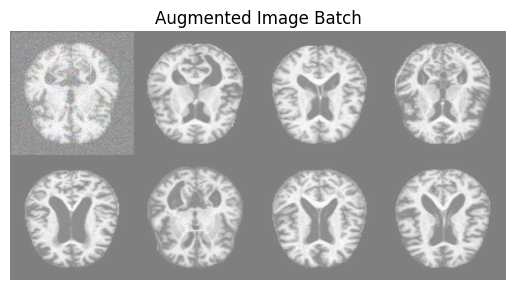

In [22]:
def show_batch(loader):
    imgs, lbls = next(iter(loader))
    img_grid = make_grid(imgs[:8], nrow=4)
    npimg = img_grid.numpy().transpose((1, 2, 0))
    plt.imshow((npimg * 0.5 + 0.5))  # de-normalize
    plt.title("Augmented Image Batch")
    plt.axis('off')
    plt.show()

show_batch(train_loader)

In [23]:
class SatyaCNN(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,3, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64,128,3, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128,256,3, padding =1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*14*14,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,4)
        )

    def forward(self, x) :
        x = self.conv(x)
        return self.fc(x)

cnn = SatyaCNN()

In [24]:
!pip install prettytable


In [25]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(cnn)

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| conv.0.weight |    864     |
|  conv.0.bias  |     32     |
| conv.3.weight |   18432    |
|  conv.3.bias  |     64     |
| conv.6.weight |   73728    |
|  conv.6.bias  |    128     |
| conv.9.weight |   294912   |
|  conv.9.bias  |    256     |
|  fc.1.weight  |  25690112  |
|   fc.1.bias   |    512     |
|  fc.3.weight  |   131072   |
|   fc.3.bias   |    256     |
|  fc.5.weight  |   32768    |
|   fc.5.bias   |    128     |
|  fc.7.weight  |    512     |
|   fc.7.bias   |     4      |
+---------------+------------+
Total Trainable Params: 26243780


26243780

In [26]:
# EFFICIENTNET B5
def get_efficientnet() :
    model = EfficientNet.from_pretrained('efficientnet-b5')
    in_features = model._fc.in_features
    model._fc = nn.Sequential(
        nn.Linear(in_features, 512),  # 1st FC layer
        nn.ReLU(),
        nn.Linear(512, 256),          # 2nd FC layer
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128, 4)             # Output
    )
    return model 

In [27]:
model = get_efficientnet()

for param in model.parameters():
        param.requires_grad = False
for param in model._fc.parameters():
    param.requires_grad = True

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 123MB/s]  


Loaded pretrained weights for efficientnet-b5


In [28]:
def get_vgg16():
    model = vgg16(pretrained=True)
    
    model.classifier = nn.Sequential(
        nn.Linear(25088, 1024),
        nn.ReLU(),
        
        nn.Linear(1024, 512),
        nn.ReLU(),
        
        nn.Linear(512, 256),
        nn.ReLU(),

        nn.Linear(256,128),
        nn.ReLU(),
        
        nn.Linear(128, 4)
    )
    
    return model

In [29]:
model = get_vgg16()

for param in model.parameters():
        param.requires_grad = True


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 225MB/s] 


In [30]:
# import torch

# class_counts = [717, 52, 2560, 1795]
# total_samples = sum(class_counts)
# num_classes = len(class_counts)

# class_weights = [total_samples / (num_classes * count) for count in class_counts]

# weights_tensor = torch.tensor(class_weights, dtype=torch.float)
# print(weights_tensor)


In [31]:
def train_model(model, name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(15):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()

        print(f"[{name}] Epoch {epoch+1} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"{name}_best.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= 4:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [32]:
# 7. Train All Models
models = {
    'CustomCNN': SatyaCNN(),
    'VGG16': get_vgg16(),
    'EffNetB5': get_efficientnet()
}



history = {}
for name, model in models.items():
    print(f"\nTraining {name}")
    history[name] = train_model(model, name)


Loaded pretrained weights for efficientnet-b5

Training CustomCNN
[CustomCNN] Epoch 1 | Train Loss: 1.2437, Train Acc: 0.3660 | Val Loss: 1.1919, Val Acc: 0.3960
[CustomCNN] Epoch 2 | Train Loss: 1.2003, Train Acc: 0.3963 | Val Loss: 1.1877, Val Acc: 0.4010
[CustomCNN] Epoch 3 | Train Loss: 1.1717, Train Acc: 0.4123 | Val Loss: 1.1766, Val Acc: 0.4030
[CustomCNN] Epoch 4 | Train Loss: 1.1723, Train Acc: 0.4043 | Val Loss: 1.1970, Val Acc: 0.3970
[CustomCNN] Epoch 5 | Train Loss: 1.1252, Train Acc: 0.4443 | Val Loss: 1.0291, Val Acc: 0.4770
[CustomCNN] Epoch 6 | Train Loss: 0.9174, Train Acc: 0.5497 | Val Loss: 0.8287, Val Acc: 0.5810
[CustomCNN] Epoch 7 | Train Loss: 0.7567, Train Acc: 0.6287 | Val Loss: 0.7488, Val Acc: 0.6080
[CustomCNN] Epoch 8 | Train Loss: 0.6822, Train Acc: 0.6470 | Val Loss: 0.6549, Val Acc: 0.6740
[CustomCNN] Epoch 9 | Train Loss: 0.6373, Train Acc: 0.6700 | Val Loss: 0.6162, Val Acc: 0.6770
[CustomCNN] Epoch 10 | Train Loss: 0.6165, Train Acc: 0.6750 | Val Los

In [33]:
# 9. Evaluate on Test Set
def evaluate(model, name):
    model.load_state_dict(torch.load(f"{name}_best.pth"))
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    loss_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    loss_avg = loss_total / len(test_loader)
    print(f"{name} Test Accuracy: {acc:.2f}% | Loss: {loss_avg:.4f}")
    return loss_avg, acc

test_results = {}
for name, model in models.items():
    test_results[name] = evaluate(model, name)

CustomCNN Test Accuracy: 48.63% | Loss: 1.4850
VGG16 Test Accuracy: 50.04% | Loss: 1.3109
EffNetB5 Test Accuracy: 64.74% | Loss: 1.6134


In [42]:
from sklearn.metrics import confusion_matrix
import numpy as np
 
# At end of validation loop
all_preds, all_labels = [], []

for name, model in models.items() : 
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
     
    print("Confusion Matrix:\n",name,'\n' ,confusion_matrix(all_labels, all_preds),'\n' )

Confusion Matrix:
 CustomCNN 
 [[147   0   6  26]
 [  5   3   0   4]
 [176   1 326 137]
 [212   1  89 146]] 

Confusion Matrix:
 VGG16 
 [[147   0 185  26]
 [  5   3  12   4]
 [176   1 966 137]
 [212   1 537 146]] 

Confusion Matrix:
 EffNetB5 
 [[ 199    0  228  110]
 [   5   12   12    7]
 [ 179    1 1409  331]
 [ 215    1  658  470]] 

